# Youtube TSN video title analysis

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import requests
from collections import Counter
from multiprocessing import Pool
from dateparser import parse as dtparse
from itertools import chain

%matplotlib inline

In [2]:
!ls data

processed_data.jl.gz tsn_ready.csv
tsn.txt              tsn_scraped_data.csv


## Get links to all playlists

In [ ]:
# tsn.txt = downloaded html data

with open("data/tsn.txt") as fp:
    soup = BeautifulSoup(fp)

In [ ]:
vec = soup.find_all('a', {'id':'video-title'})

In [ ]:
my_href = []
my_text = []

for i in vec:
    if i.get('href'):
        #if i.text.startswith('ТСН.19:30'):
        href = my_href.append('https://www.youtube.com' + i.get('href'))
        text = my_text.append(i.text)

In [ ]:
url = my_href[0]
r = requests.get(url)

In [ ]:
soup = BeautifulSoup(r.text)
video_list = soup.find_all('li', {'class':'vve-check'})

In [ ]:
video_list[0].get('data-video-title')

## Create DF

In [ ]:
df = pd.DataFrame(columns = 
                  ['list_link', 'list_title', 'video_link', 'video_title'])

In [ ]:
for i in range(len(my_href)):
    soup = BeautifulSoup(requests.get(my_href[i]).text)
    video_list = soup.find_all('li', {'class':'vve-check'})
    
    for video in video_list:
        df = df.append({'list_link' : my_href[i],
                        'list_title': my_text[i],
                        'video_link': ('https://www.youtube.com' + video.a.get('href')), 
                        'video_title' : video.get('data-video-title')}, 
                        ignore_index=True)


In [ ]:
len(df)

In [ ]:
# get only needed programs

boolvec = df['list_title'].str.contains('ТСН.Ранок|ТСН.12:00|ТСН.16:45|ТСН.19:30|ТСН.Ніч|ТСН.Тиждень', regex=True)
df = df[boolvec].reset_index(drop=True)

In [ ]:
# split variable list_title

new = df['list_title'].str.split(" за ", n = 1, expand = True) 
df['program_name'] = new[0]
df['date'] = new[1]

In [ ]:
# variable to filter full video

boolvec = df['video_title'].str.startswith('Випуск ТСН')
df['is_full_video'] = boolvec

In [ ]:
df.head(1)

In [ ]:
#df.to_csv('data/tsn_scraped_data.csv')

## Data cleaning

In [ ]:
df = pd.read_csv('data/tsn_scraped_data.csv', index_col=0)
df = df[df.is_full_video == False].reset_index(drop=True)
df = df.drop(['is_full_video'], axis = 1)

In [ ]:
df.head()

In [ ]:
len(df)

### Lemmatization

In [ ]:
df['video_title_old'] = df['video_title']

df.video_title = (df.video_title
                  .str.lower()    # lowercase
                  .str.replace(r'[^\w\s!\']', ' ')    # remove punctuations
                  .str.replace(r' +', ' ')    # remove extra spaces  
                  .str.strip() # remove extra spaces from the begining and at the end of string
                 )

In [ ]:
# load lemmatizator

lemmatiz_dict = pd.read_csv('dictionaries/lemmatization-uk.txt', sep="\t", names = ['to', 'from'])
lemmatiz_dict.index = lemmatiz_dict['from']
lemmatiz_dict = lemmatiz_dict.drop('from', axis = 1).to_dict() 
lemmatiz_dict = lemmatiz_dict['to']

# add more words

lemmatiz_dict.update({
    'підозрюваного': 'підозрюваний',
    'підозрювану': 'підозрюваний',
    'підозрювана': 'підозрюваний',
    'підозрюваному': 'підозрюваний',
    'підозрюваній': 'підозрюваний',
    'києва': 'київ',
    'києві': 'київ',
    'києвом': 'київ',
    'москві': 'москва',
    'москву': 'москва',
    'москвою': 'москва',
    'потужний': 'потужно',
    'звільнити': 'звільняти',
    'обстріляли': 'обстрілювати',
    'порошенка': 'порошенко',
    'порошенку': 'порошенко',
    'зеленського': 'зеленський',
    'зеленському': 'зеленський',
    'ведучу': 'ведуча',
    'ведучої': 'ведуча',
    'ведучій': 'ведуча',
    'ведучого': 'ведучий',
    'ведучому': 'ведучий',
    'україни' : 'україна',
    'україною' : 'україна',
    'україні' : 'україна',
    'україну' : 'україна',
    'українська': 'український',
    'українка': 'українець/нка',
    'українку': 'українець/нка',
    'українкою': 'українець/нка',
    'українки': 'українець/нка',
    'українець': 'українець/нка',
    'українця': 'українець/нка',
    'українцю': 'українець/нка',
    'українцям': 'українець/нка',
    'київщині': 'київ',
    'київщини': 'київ',
    'києва': 'київ',
    'києві': 'київ',
    'києву': 'київ',
    'львові': 'львів',
    'львова': 'львів',
    'львовом': 'львів',
    'львівщині': 'львів',
    'львівщину': 'львів',
    'львівщиною': 'львів',
    'росії': 'росія',
    'росію': 'росія',
    'росією': 'росія',
    'одещині': 'одеса',
    'одещиною': 'одеса',
    'одещини': 'одеса',
    'одесі': 'одеса',
    'одесою': 'одеса',
    'одеси': 'одеса',
    'запоріжжі': 'запоріжжя',
    'харкові': 'харків',
    'харкову': 'харків',
    'харковом': 'харків',
    'бездіяльності' : 'бездіяльність',
    'бездіяльності' : 'бездіяльність',
    'бездіяльності' : 'бездіяльність',
    'осліпла' : 'осліп',
    'осліпли' : 'осліп',
    'осліплена' : 'осліп',
    'осліплений' : 'осліп',
    'нелегальна': 'нелегально',
    'нелегальний': 'нелегально',
    'нелегальні': 'нелегально',
    'гармату': 'гармата',
    'гармати': 'гармата',
    'мінометів' : 'міномет', 
    'міномети' : 'міномет', 
    'мінометний' : 'міномет', 
    'бронемашин': 'бронемашина',
    'бронемашину': 'бронемашина',
    'бронемашині': 'бронемашина',
    'бронемашиною': 'бронемашина',
    'бронемашини': 'бронемашина',
    'обстрілів': 'обстріл',
    'обстрілу': 'обстріл',
    'обстріли': 'обстріл',
    'обстрілами': 'обстріл',
    'політв\'язнів': 'політв\'язень',
    'політв\'язня': 'політв\'язень',
    'політв\'язню': 'політв\'язень',
    'політв\'язні': 'політв\'язень',
    'політв\'язнями': 'політв\'язень',
    'політв\'язнем': 'політв\'язень',
    'зарубав': 'зарубати',
    'зарубала': 'зарубати',
    'зарубили': 'зарубити',
    'зарублений': 'зарубати',
    'зарублениа': 'зарубати'
})

In [ ]:
# lemmatize
df.video_title = (df.video_title
                  .str.split()
                  .apply(lambda s: [lemmatiz_dict.get(w, w) for w in s])
                 )

In [ ]:
# delete numbers and stop words

with open('dictionaries/ukrainian-stopwords.txt') as f:
    ukr_stopwords = f.read().split(sep='\n')
    ukr_stopwords += ['із','а', 'який','аби','й','щодо','біля', 'го', 'ій', 'о', 'тсн']

df.video_title = df.video_title.apply(
    lambda s: ' '.join(filter(
        lambda w: (not w.isdigit()) and (not w in ukr_stopwords),
        s
    ))
).str.replace(' +', ' ').str.strip()

In [ ]:
df.head(2)

### Tone words

In [ ]:
# split by word 

df['video_title'] = df['video_title'].str.split()

In [27]:
# get the tone_dict

tone_dict = pd.read_csv('dictionaries/tone-dict-uk.tsv', sep='\t', names=['word', 'tone'])
tone_dict.head(5)

,word,tone
0,Всевишній,1
1,Господь,1
2,Христовий,1
3,аборт,-1
4,абсурд,-1


In [28]:
# Change tone indexes

tone_dict.word = tone_dict.word.str.lower()
tone_dict.tone = (tone_dict.tone > 0).astype(int)
tone_dict.loc[tone_dict.tone == 0, 'tone'] = -1

In [29]:
tone_dict = dict(tone_dict.values)

# add more words

tone_dict.update({
    'тортури': -1,
    'збити': -1,
    'підозрюваний': -1, 
    'замінування': -1,
    'полонений': -1,
    'полонена': -1,
    'пожежа'
    'дтп': -1,
    'врятувати': 1,
    'фронт': -1,
    'поранення': -1, 
    'поранені': -1,
    'бойовик': -1,
    'вибухнути': -1,
    'рятувальник': -1,
    'рятувальники': -1,
    'фестиваль': 1,
    'поранений': -1,
    'поранена': -1,
    'викрасти': -1,
    'стрілянина': -1,
    'згоріти': -1,
    'політв\'язень': -1,
    'теракти': -1,
    'розгін': -1,
    'дтп': -1,
    'п\'яний': -1,
    'п\'яна': -1,
    'розстріляти' : -1,
    'вистрелив': -1,
    'вистрелила': -1,
    'крадений': -1,
    'обвалився': -1,
    'обвалилася': -1,
    'затопити': -1,
    'заблоковані': -1,
    'затримання' : -1,
    'загорітися': -1,
    'бездіяльності' : -1,
    'бездіяльність' : -1,
    'осліпла' : -1,
    'осліп': -1,
    'небезпека': -1,
    'нелегально': -1,
    'заарештувати': -1,
    'гармата': -1,
    'міномет' : -1, 
    'бронемашина': -1,
    'погроза': -1,
    'обстріл' : -1,
    'вчаділи': -1,
    'політв\'язень': -1,
    'зарубати' : -1,
    'повісити': -1,
    'син': 1,
    'кораблетрощі': -1
})

In [ ]:
# variable with words from tone_dict
df['tone_words'] =  df.video_title.apply(
    lambda s: list(filter(
        lambda w: w in tone_dict,
        s
    ))
)

In [ ]:
print(f'Number of rows with tone is {(df.tone_words.apply(len) > 0).value_counts()[True]}, '
      f'without tone is {df.tone_words.apply(len).value_counts()[0]}'
     )

In [ ]:
df['negative_tone'] = df.tone_words.apply(
    lambda s: any(tone_dict[w] == -1 for w in s)
)

In [8]:
# fix error 

df.loc[df.program_name.str.match('ТСН.Тиждень з 22 вересня 2019 року'), 'program_name'] = 'ТСН.Тиждень'
df.loc[df.video_link.str.match('.+list=PL1neMztLSbMNg1b78ylPRbaU8PVSpWZoQ\&'), 'date'] = '22 вересня 2019'

In [ ]:
with Pool(12) as p:
    df.date = p.map(dtparse, df.date.str.replace(' року$', '').values)

In [ ]:
df = df.loc[
    (df.date > '2018-12-31') &
    (df.date < '2019-10-01')
].copy().reset_index(drop=True)

In [ ]:
# df.to_json('processed_data.jl.gz', orient='records', lines=True, compression='gzip', force_ascii=False)

## Look at basic things

In [18]:
df_total = pd.read_json('data/processed_data.jl.gz', lines=True)

In [19]:
boolvec = df_total['list_title'].str.contains('ТСН.19:30|ТСН.Тиждень', regex=True)
df = df_total.loc[boolvec].copy().reset_index(drop=True)

In [20]:
df.head(1)

,list_link,list_title,video_link,video_title,program_name,date,video_title_old,tone_words,negative_tone,negative_saldo
0,https://www.youtube.com/watch?v=XzPMIJy2tUw&li...,ТСН.19:30 за 30 вересня 2019 року,https://www.youtube.com/watch?v=XzPMIJy2tUw&li...,"[поліція, відкрити, кримінальний, справа, вбив...",ТСН.19:30,2019-09-30,Поліція відкрила дві кримінальні справи щодо в...,"[кримінальний, вбивство]",True,True


In [21]:
# Кількість спостережень

len(df)

5862

In [22]:
# Відсоток емоційних заголовків

round((sum(df.negative_tone) / len(df)) * 100, ndigits=1)

41.7

In [23]:
# Відсоток емоційних заголовків (січень-червень)

round((sum(df[df['date'] < '2019-07-01'].negative_tone) / len(df[df['date'] < '2019-07-01'])) * 100,ndigits=1)

42.4

## The most popular words (total and from tone dictionary)

### Total the most popular words

In [24]:
common_all = Counter(chain(*df.video_title))
print('Total words', sum(common_all.values()))
common_all.most_common(10)

Total words 42778


[('україна', 470),
 ('київ', 310),
 ('український', 303),
 ('річний', 278),
 ('загинути', 200),
 ('президент', 181),
 ('новий', 179),
 ('свій', 177),
 ('чоловік', 172),
 ('зеленський', 170)]

In [25]:
common_all['порошенко'], Counter(chain(*df_total.video_title))['порошенко']

(69, 155)

### The most popular negative tone words

In [30]:
df['tone_words_neg'] = df.tone_words.apply(
    lambda s: list(filter(
        lambda w: tone_dict[w] < 0,
        s
    ))
)

In [31]:
neg_counter = Counter(chain(*df.tone_words_neg))
neg_counter.most_common(10)

[('загинути', 200),
 ('затримати', 85),
 ('бойовик', 66),
 ('дтп', 61),
 ('вбивство', 60),
 ('смерть', 57),
 ('вимагати', 53),
 ('вибух', 51),
 ('померти', 50),
 ('жертва', 46)]

## Time of program

In [32]:
df['video_number'] = df.video_link.str.extract('\&index=(\d{1,3})', expand=False).astype(int)

In [33]:
def check_video_num(d):
    d['video_number'] = d.sort_values('video_number').reset_index().index + 1
    d.loc[d.video_number < 4, 'first_last_three'] = 'first'
    d.loc[d.video_number > len(d) - 3, 'first_last_three'] = 'last'
    d.first_last_three = d.first_last_three.fillna('middle')
    d['first_half'] = d.video_number < len(d)/2
    return d

In [34]:
df = df.groupby('date').apply(check_video_num)

In [35]:
pivot_num_video3 = df.pivot_table(index='first_last_three', values='negative_tone', aggfunc='sum')

# new variable with %
pivot_num_video3['total'] = pd.Series.value_counts(df['first_last_three'])
pivot_num_video3['percent_negative'] = round(
    pivot_num_video3['negative_tone']/pivot_num_video3['total']*100, 
    ndigits=1)

# format df
pivot_num_video3 = pivot_num_video3.style.format({'percent_negative':'{:.1f}%'})

pivot_num_video3

,negative_tone,total,percent_negative
first_last_three,,,
first,475,807,58.9%
last,184,807,22.8%
middle,1786,4248,42.0%


### Emotions of first and last 50% of program

In [36]:
pivot_num_video = df.pivot_table(index='first_half', values='negative_tone', aggfunc='sum')

pivot_num_video['percent_negative'] = round(pivot_num_video['negative_tone'] / 
                                            pd.Series.value_counts(df['first_half'])
                                            * 100, ndigits=1)

pivot_num_video = pivot_num_video.style.format({'percent_negative':'{:.1f}%'})

pivot_num_video

,negative_tone,percent_negative
first_half,,
False,1055,33.7%
True,1390,51.0%


## Zelenskyi VS Poroshenko

### Total number of president's last name each month

In [37]:
df.video_title = df.video_title.apply(lambda s: ' '.join(s))

In [38]:
df['Poroh'] = False
df['Ze'] = False

df.loc[df.video_title.str.contains('порошенко'), 'Poroh'] = True
df.loc[df.video_title.str.contains('зеленський'), 'Ze'] = True

In [39]:
df['month'] = df.date.dt.month

pivot_num_video = df.pivot_table(index='month', values='Ze', aggfunc='sum')
pivot_num_video['Poroh'] = df.pivot_table(index='month', values='Poroh', aggfunc='sum')

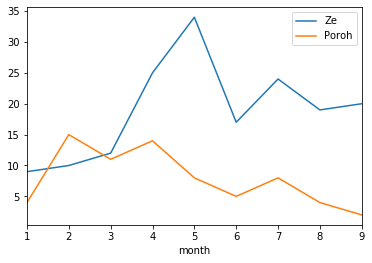

In [40]:
pivot_num_video[['Ze', 'Poroh']].plot()

### Negative number

In [41]:
df['Ze_neg'] = df.Ze & df.negative_tone
df['Poroh_neg'] = df.Poroh & df.negative_tone

In [42]:
print('В ' + \
      str(round(df.Poroh_neg.sum()/df.Poroh.sum() * 100, ndigits=1)) + \
      '% випадках Порошенка згадували разом зі словами, що викликають негативні емоції' + \
      '\nПрізвище Зеленського стояло поруч із негативними словами лише в ' + \
      str(round(df.Ze_neg.sum()/df.Ze.sum() * 100, ndigits=1)) + '% разів')

В 36.6% випадках Порошенка згадували разом зі словами, що викликають негативні емоції
Прізвище Зеленського стояло поруч із негативними словами лише в 20.0% разів


## Negative dynamics

### By month

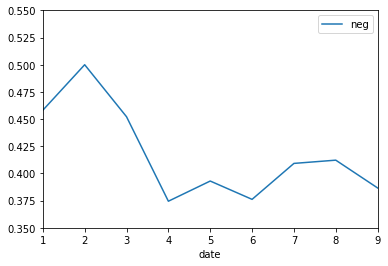

In [43]:
(df.groupby(df.date.dt.month).negative_tone
 .value_counts(normalize=True)
 .to_frame('neg')
 .reset_index('date') .loc[True]
 .reset_index(drop=True)
 .set_index('date')
).plot(kind='line', ylim=[0.35, 0.55])

### By week

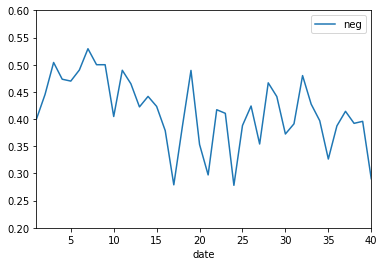

In [44]:
(df.groupby(df.date.dt.week).negative_tone
 .value_counts(normalize=True)
 .to_frame('neg')
 .reset_index('date') .loc[True]
 .reset_index(drop=True)
 .set_index('date')
).plot(kind='line', ylim=[0.2, 0.6])

### % of most popular negative 5 words among all titles

In [45]:
popular = ['загинути', 'затримати', 'дтп', 'поранення', 'фронт']

In [46]:
df.video_title.str.contains('|'.join(popular)).value_counts(normalize=True)

False    0.933982
True     0.066018
Name: video_title, dtype: float64

## 'загинути' dynamics

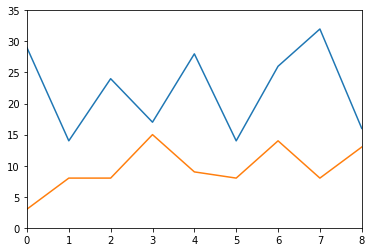

In [47]:
(df.groupby(df.date.dt.month)
 .apply(lambda d: d.video_title.str.contains('загинути').value_counts()[True])
 .reset_index()[0]
).plot(ylim=(0,35))

# source: https://novynarnia.com/2019/10/02/taymlayn-vtrat-ukrayinskoyi-armiyi-veresen-2019-infografika/
pd.Series([3,8,8,15,9,8,14,8,13]).plot()

In [48]:
df.to_csv('data/tsn_ready.csv', index=False)